In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from pathlib import Path

from cycler import cycler

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


from matplotlib import rcParams

import numpy as np
import pandas as pd


import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import geopandas as gpd

import intro_plots as ip

paper_path = Path('../paper/figures/')

slide_path = Path('../slides/figures/intro/')
proposal_path = Path('../draft/figures/intro/')
#rcParams['font.family'] = 'Segoe Print'

PROJ: proj_create_from_database: Cannot find proj.db


In [5]:
ny_all = pd.read_csv("nydata")

ny = ny_all[ny_all['NAME'].isin(ip.cdict.keys())].copy()

ny['DATES'] = pd.to_datetime(ny['DATE'])

In [6]:
nyjfk = ny[ny['NAME'].str.contains('JFK')].fillna(0)[['DATES', 'PRCPI', 'PRCP']]

In [7]:
nyjfk['PRCPI2'] = nyjfk['PRCPI']*10

<AxesSubplot:>

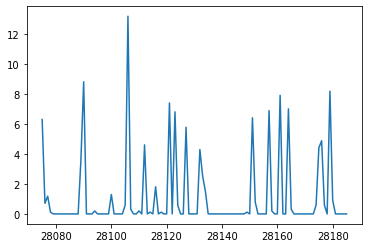

In [8]:
nyjfk['PRCPI2'].plot()

In [9]:
nyjfk['PRCPMM'] = nyjfk['PRCP']/10

In [10]:
dfs = nyjfk[(nyjfk['DATES']>'2021-02-04') & (nyjfk['DATES']<'2021-02-15')]
dfs

,DATES,PRCPI,PRCP,PRCPI2,PRCPMM
28110,2021-02-05,0.019685,5.0,0.19685,0.5
28111,2021-02-06,0.000000,0.0,0.00000,0.0
28112,2021-02-07,0.460629,117.0,4.60629,11.7
28113,2021-02-08,0.000000,0.0,0.00000,0.0
28114,2021-02-09,0.011811,3.0,0.11811,0.3
28115,2021-02-10,0.000000,0.0,0.00000,0.0
28116,2021-02-11,0.181102,46.0,1.81102,4.6
28117,2021-02-12,0.000000,0.0,0.00000,0.0
28118,2021-02-13,0.011811,3.0,0.11811,0.3
28119,2021-02-14,0.000000,0.0,0.00000,0.0


In [12]:
dfs['L1'] = dfs['PRCPMM'].apply(lambda x: f"{x:1.2f}") 
dfs['L2'] = dfs['PRCP'].apply(lambda x: f"{x:1.4f}") 

<ipython-input-12-bdac8ed1376c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['L1'] = dfs['PRCPMM'].apply(lambda x: f"{x:1.2f}")
<ipython-input-12-bdac8ed1376c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['L2'] = dfs['PRCP'].apply(lambda x: f"{x:1.4f}")


In [64]:
def make_plot(sout, labels=None, paper=False):
    labels = [] if labels is None else labels
   
            
    gridspec_kw={'height_ratios':[1,3]}
    fig, axd = plt.subplot_mosaic([['table','time'], ['table', 'twin']],
                                  constrained_layout=True, 
                                  gridspec_kw={'width_ratios':[1,2]},
                                  figsize=(16,4))
                                    
    for n in axd.keys():
        if n not in labels:
            axd[n].axis('off')
    #gridspec_kw={'width_ratios':}

    ocolor = 'tab:blue'
    scolor = 'tab:green'
    gcolor = 'tab:orange'
    if 'scale' not in labels:
        table = ip.plot_table(axd['table'], dfs[['DATES', 'L1']], ['k', ocolor], textcolor=None)
        fig.canvas.draw()
        table[(0,1)].get_text().set_text('PRECIP (mm)')
    elif 'scale' in labels:
        table = ip.plot_table(axd['table'], dfs[['DATES', 'L1', 'PRCPI', 'L2']], ['k', ocolor, 'white', scolor], textcolor=None)
        fig.canvas.draw()
        table[(0,1)].get_text().set_text('PRECIP (mm)')
        table[(0,3)].get_text().set_text('PRECIP (cm)')
        table[0,2].visible_edges = 'vertical'
        table[0,2].get_text().set_text(r"$\times$ 10") #25.4#÷10 * 0.039370
        table[0,2].get_text().set_color('black')
        for i in range(1,len(dfs)+1):
            table[i,2].visible_edges = 'vertical'
            x1, y1 = ip.source_cell(table[i,1], ocolor, xr=.55)
            x2, y2 = ip.source_cell(table[i,3], scolor, xr=.65)

            arrow = mpatches.ConnectionPatch(xyA=(x1, y1), coordsA=axd['table'].transData,
                                             xyB=(x2, y2), coordsB=axd['table'].transData,   
                                             arrowstyle="fancy", mutation_scale=20, 
                                             facecolor=gcolor, edgecolor='black', alpha=galpha)
            fig.add_artist(arrow)
         

    
    axt = axd['twin'].twinx()
    if 'twin' not in labels: 
        axt.axis('off')
    for n in ['time', 'twin']:
        if n not in labels:
            continue
        axd[n].plot('DATES', 'PRCPMM', data=nyjfk, color=ocolor, zorder=10, lw=3, label='precipitation (mm)')
    

    for n, ax, ls in [('time', axd['time'], '-'), ('twin', axt, ':')]:
        if n not in labels:
            continue
        ax.plot('DATES', 'PRCP', data=nyjfk, color=scolor, zorder=9, lw=3, label='precipitation (cm)', 
                linestyle=ls)

            
        axd['time'].xaxis.set_label_position('bottom')
        axd['time'].yaxis.set_label_position('right')
        axd['time'].legend(ncol=2, labelcolor='linecolor')
    
    for n, ax in [(None, axt), ('twin', axd['twin']), ('time', axd['time'])]:
        if n not in labels:
            continue
            ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
            ax.set_xlim(nyjfk['DATES'].min(), nyjfk['DATES'].max())
            ax.set_ylim(0)


    if 'twin' in labels:
        axd['twin'].tick_params('y', color=ocolor, labelcolor=ocolor)
        axt.tick_params('y', color=scolor, labelcolor=scolor)


    
    if paper:
        axd['time'].set_xlabel("(b)", fontsize='large')
        axd['twin'].set_xlabel("(c)", fontsize='large')
        axd['table'].set_title("(a)", y=-.05, fontsize='large')

   
   
    #fig.savefig(proposal_path/"equivariant.png", dpi = 200)
    fig.savefig(sout, bbox_inches='tight', facecolor='white', dpi=200)
    plt.show()

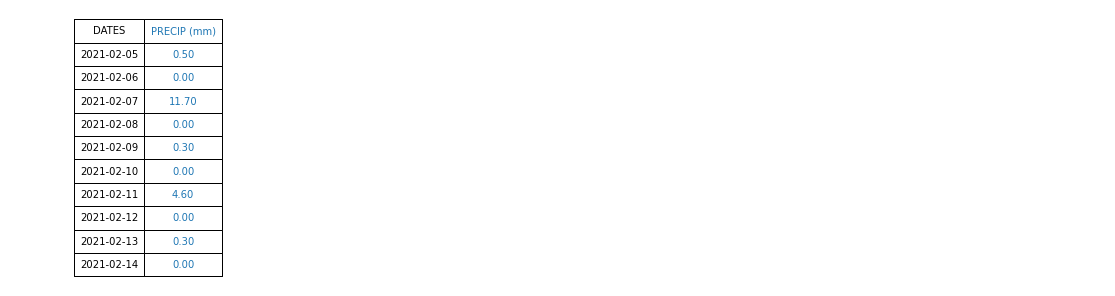

In [65]:
make_plot("e0")

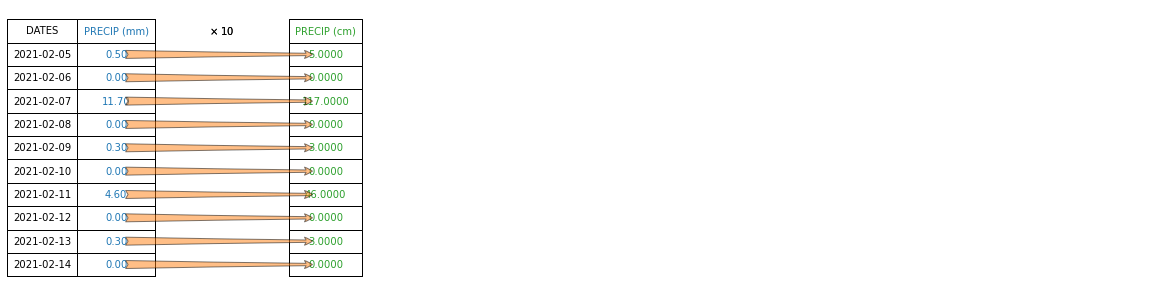

In [66]:
make_plot('e1', ['scale'])

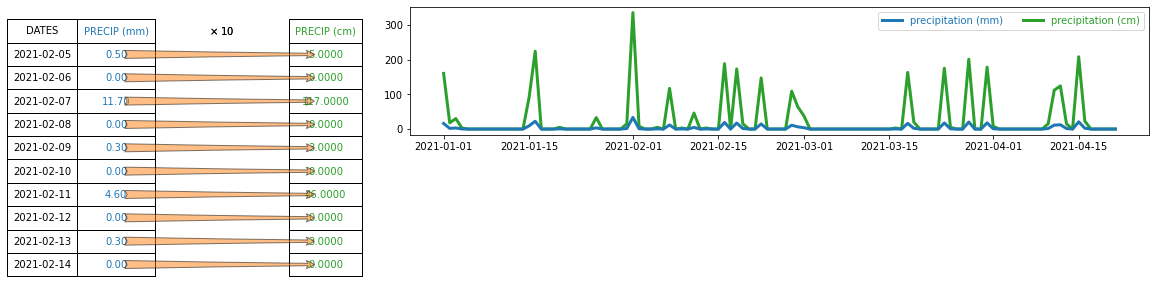

In [69]:
make_plot('e2', ['scale', 'time'])

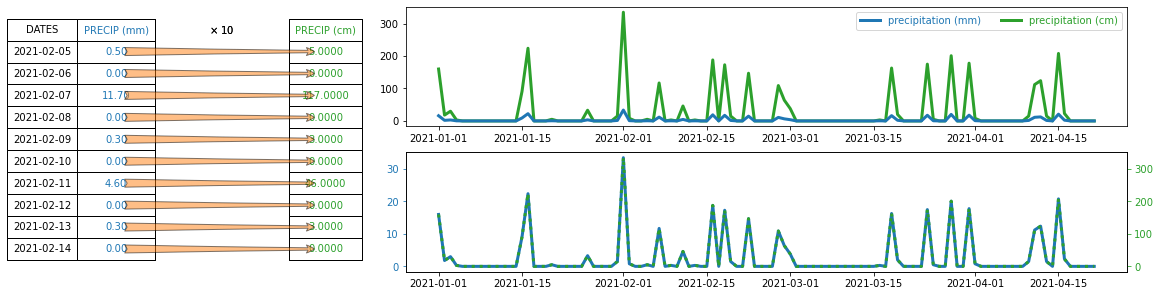

In [70]:
make_plot('e3', ['scale', 'time', 'twin'])